In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py

tf.get_logger().setLevel('ERROR')
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.77.0.22)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by Combell (Brussels) [2.15 km]: 10.749 ms
Testing download speed................................................................................
Download: 1108.16 Mbit/s
Testing upload speed......................................................................................................
Upload: 787.57 Mbit/s


# Import dataset

In [ ]:
from google.colab import drive
import os

drive.mount('/content/GoogleDrive', force_remount=True)
path = '/content/GoogleDrive/My Drive/Vietnamese Foods'
os.chdir(path)
!ls

Mounted at /content/GoogleDrive
'add shorcut to drive.png'  'Guideline gán nhãn.pdf'   Template.ipynb
 Backup			     Models		      'Test gán nhãn.gsheet'
 Dataset		     ResNet152V2	      'Vietnamese Foods.gsheet'


In [ ]:
!cp Dataset/vietnamese-foods-split.zip /tmp
!unzip -q /tmp/vietnamese-foods-split.zip -d /tmp

## Check GPU working

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)

Found GPU at: /device:GPU:0


# Setup path

In [ ]:
TRAIN_PATH = '/tmp/Images/Train'
VALIDATE_PATH = '/tmp/Images/Validate'
TEST_PATH = '/tmp/Images/Test'

In [ ]:
PATH = 'Models/InceptionResNetV2'

BASE_MODEL_BEST = os.path.join(PATH, 'base_model_best.hdf5')
BASE_MODEL_TRAINED = os.path.join(PATH, 'base_model_trained.hdf5')
BASE_MODEL_FIG = os.path.join(PATH, 'base_model_fig.jpg')

FINE_TUNE_MODEL_BEST = os.path.join(PATH, 'fine_tune_model_best.hdf5')
FINE_TUNE_MODEL_TRAINED = os.path.join(PATH, 'fine_tune_model_trained.hdf5')
FINE_TUNE_MODE_FIG = os.path.join(PATH, 'fine_tune_model_fig.jpg')

# Preparing data

In [ ]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 128

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
validate_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
generated_train_data = train_generator.flow_from_directory(TRAIN_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_validate_data = validate_generator.flow_from_directory(VALIDATE_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_test_data = test_generator.flow_from_directory(TEST_PATH, target_size=IMAGE_SIZE)

Found 17581 images belonging to 30 classes.
Found 2515 images belonging to 30 classes.
Found 5040 images belonging to 30 classes.


# Model implement

In [ ]:
CLASSES = 30
INITIAL_EPOCHS = 15
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
FINE_TUNE_AT = 711

## Define the model

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [ ]:
pretrained_model = InceptionResNetV2(weights='imagenet', include_top=False)
last_output = pretrained_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

219062272/219055592 [==============================] - 2s 0us/step


## Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
base_checkpointer = ModelCheckpoint(
    filepath = BASE_MODEL_BEST, 
    save_best_only = True, 
    verbose = 1
)

fine_tune_checkpointer = ModelCheckpoint(
    filepath = FINE_TUNE_MODEL_BEST, 
    save_best_only = True,
    verbose = 1, 
)

# Stop if no improvement after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

## Stage 1: Transfer learning

In [ ]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)

Epoch 1/15
 27/137 [====>.........................] - ETA: 7:54 - loss: 3.1909 - accuracy: 0.1826

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


137/137 [==============================] - 684s 5s/step - loss: 2.2591 - accuracy: 0.3519 - val_loss: 1.6861 - val_accuracy: 0.4634

Epoch 00001: val_loss improved from inf to 1.68613, saving model to Models/InceptionResNetV2/base_model_best.hdf5
Epoch 2/15
137/137 [==============================] - 659s 5s/step - loss: 1.6560 - accuracy: 0.4904 - val_loss: 1.4435 - val_accuracy: 0.5715

Epoch 00002: val_loss improved from 1.68613 to 1.44345, saving model to Models/InceptionResNetV2/base_model_best.hdf5
Epoch 3/15
137/137 [==============================] - 637s 5s/step - loss: 1.4794 - accuracy: 0.5462 - val_loss: 1.4848 - val_accuracy: 0.5502

Epoch 00003: val_loss did not improve from 1.44345
Epoch 4/15
137/137 [==============================] - 625s 5s/step - loss: 1.3736 - accuracy: 0.5753 - val_loss: 1.2606 - val_accuracy: 0.6283

Epoch 00004: val_loss improved from 1.44345 to 1.26058, saving model to Models/InceptionResNetV2/base_model_best.hdf5
Epoch 5/15
137/137 [==============

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

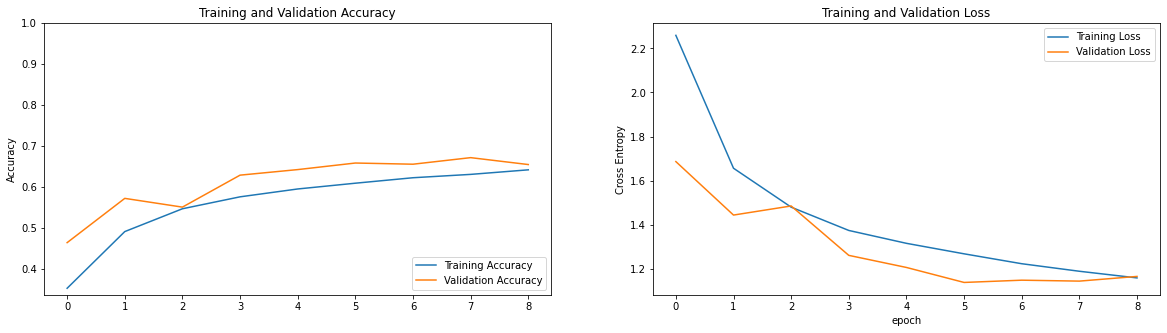

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(BASE_MODEL_FIG)
plt.show()

## Stage 2: Fine tuning

In [ ]:
for layer in pretrained_model.layers[:FINE_TUNE_AT]: layer.trainable = False
for layer in pretrained_model.layers[FINE_TUNE_AT:]: layer.trainable = True

In [ ]:
from tensorflow.keras.optimizers import SGD
model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [ ]:
history_fine = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    callbacks = [fine_tune_checkpointer, early_stopping],
    verbose = 1,
)
model.save(FINE_TUNE_MODEL_TRAINED)

Epoch 9/30
 12/137 [=>............................] - ETA: 8:57 - loss: 2.0316 - accuracy: 0.4023

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


137/137 [==============================] - 660s 5s/step - loss: 1.3928 - accuracy: 0.5875 - val_loss: 1.0827 - val_accuracy: 0.6793

Epoch 00009: val_loss improved from inf to 1.08270, saving model to Models/InceptionResNetV2/fine_tune_model_best.hdf5
Epoch 10/30
137/137 [==============================] - 628s 5s/step - loss: 1.1577 - accuracy: 0.6558 - val_loss: 1.0818 - val_accuracy: 0.6797

Epoch 00010: val_loss improved from 1.08270 to 1.08175, saving model to Models/InceptionResNetV2/fine_tune_model_best.hdf5
Epoch 11/30
137/137 [==============================] - 625s 5s/step - loss: 1.1020 - accuracy: 0.6708 - val_loss: 1.0578 - val_accuracy: 0.6875

Epoch 00011: val_loss improved from 1.08175 to 1.05780, saving model to Models/InceptionResNetV2/fine_tune_model_best.hdf5
Epoch 12/30
137/137 [==============================] - 650s 5s/step - loss: 1.0573 - accuracy: 0.6866 - val_loss: 1.0456 - val_accuracy: 0.6896

Epoch 00012: val_loss improved from 1.05780 to 1.04564, saving mode

In [ ]:
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']
val_acc += history_fine.history['val_accuracy']
val_loss += history_fine.history['val_loss']

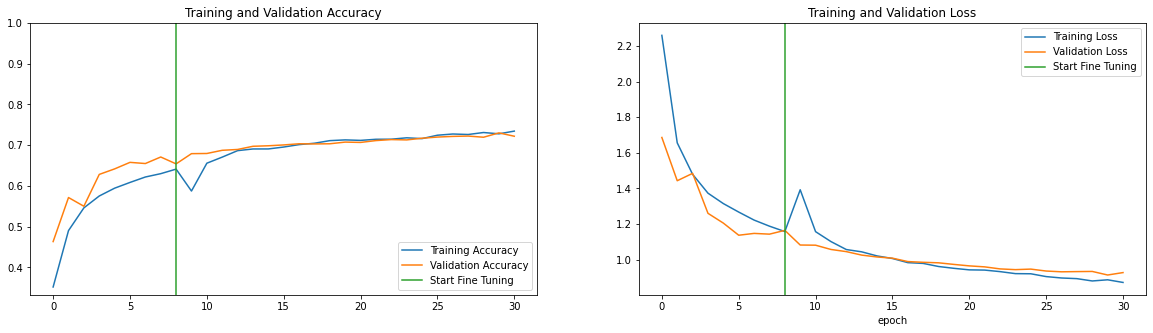

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([INITIAL_EPOCHS - 7, INITIAL_EPOCHS - 7], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot([INITIAL_EPOCHS - 7, INITIAL_EPOCHS - 7], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(FINE_TUNE_MODE_FIG)
plt.show()

# Evaluation

In [ ]:
loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

158/158 [==============================] - 90s 566ms/step - loss: 0.8840 - accuracy: 0.7292
Test accuracy: 0.7291666865348816


In [ ]:
import gc
del model
gc.collect()